# Tax Return Disclosure – Create Model

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time, enum, math
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
from tqdm import tqdm

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner, BatchRunnerMP

Set working directory if necessary

In [2]:
os.getcwd()

'/Users/johannes/GitHub/TaxReturnDisclosure_ABM/1_code'

In [3]:
os.chdir('/Users/johannes/GitHub/Income_Tax_Return_Disclosure')

## Model Class

In [4]:
class Disclosure(Model):
    """Create the Disclosure model with with a number of agents."""
    def __init__(self, N = 100, scen = 3, audit_discl = 0, blockingfour = 1, kappa = 0.01, complexity = 2.09686, neighbors = 20, rho_upper = 0.1, intr_honest = 0.05, tax_rate = 0.35, initial_avoider = 0.5):
        self.num_nodes = N
        self.scenario = scen
        self.audit_disclosure = audit_discl
        self.blocking4 = blockingfour
        nearest_neighbors = neighbors
        rewiring_prob = kappa
        self.complexity = complexity
        self.taxrate = tax_rate
        self.intrinsically_honest = intr_honest
        self.socialpressure = rho_upper
        self.initial_avoider = initial_avoider
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k=nearest_neighbors, p=rewiring_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.running = True

        """ Create agents """
        for i, node in enumerate(self.G.nodes()):
            a = TaxAgent(i + 1, self, self.taxrate, self.complexity, self.socialpressure, self.blocking4, self.audit_disclosure, self.scenario)
            self.schedule.add(a)
            """ Add the agent to a random grid cell"""
            self.grid.place_agent(a, node)
            
            """ Initially: make agents intrinsically honest or give them state = 4 which means that they will choose optimal strategy based on private expected utility in period 1 """
            initial_state = np.random.choice([0,4], p=[self.intrinsically_honest, 1 - self.intrinsically_honest])
            if initial_state == 0:
                a.state = State.INTR_HONEST
            else:
                a.state = 4

        self.datacollector = DataCollector(
            model_reporters={"Number of Honest": agg_honest,
                             "Number of Avoiders": agg_avoiders,
                             "Number of Evaders": agg_evaders,
                             "TaxRev": agg_taxrev},
            agent_reporters={"State": "state",
                             "Number Neighbors": "number_neighbors",
                             "Honest Neighbors": "number_honest_neighbors",
                             "Avoiding Neighbors": "number_avoider_neighbors",
                             "Evading Neighbors": "number_evader_neighbors",
                             "Caught Evader Neighbors": "number_unlucky_evader_neighbors",
                             "Evasion-Amount": "opt_evasion",
                             "Evasion-Value": "value_evasion",
                             "Avoidance-Amount": "opt_avoidance",
                             "Avoidance-Value": "value_avoidance",
                             "Honesty-Value": "value_honesty",
                             "Audit-Counter": "audit_counter",
                             "Audit-Prob": "audit_prob",
                             "Erwischte": "caught",
                             "Optimization Cost": "optimization_cost",
                             "Tax payment": "tax"})


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Agent Class

In [5]:
class TaxAgent(Agent):
    def __init__(self, unique_id, model, tax_rate, complexity, socialpressure, blocking4, audit_disclosure, scenario):
        super().__init__(unique_id, model)
        self.income = 1
        self.tax_rate = tax_rate
        self.penalty_rate = 1.6
        self.audit_prob = 0.05
        self.complexity = complexity
        self.risk_aversion = 10
        self.socialpressure = socialpressure
        
        """ Endow agent with random optimization cost and random social interaction intensity rho """
        self.optimization_cost = np.random.uniform(0.075,0.1)
        self.social_interaction_intensity = np.random.uniform(0,self.socialpressure)
        
        
        """ Settings (blocking4 not used in the paper) """
        self.blocking4 = blocking4
        self.audit_disclosure = audit_disclosure
        self.scenario = scenario
        
        """ Initiate Variables for first round """
        self.number_neighbors = 0
        self.number_honest_neighbors = 0
        self.number_avoider_neighbors = 0
        self.number_evader_neighbors = 0
        self.number_unlucky_evader_neighbors = 0
        self.opt_evasion = 0
        self.value_evasion = 0
        self.opt_avoidance = 0
        self.value_avoidance = 0
        self.value_honesty = 0
        self.sum_honesty = 0
        self.sum_avoidance = 0
        self.sum_evasion = 0
        self.audit_counter = 0
        self.caught = 0
        self.tax = self.tax_rate * self.income
        if self.blocking4 == 1:
            self.abstinence_period = 5
        elif self.blocking4 == 0:
            self.abstinence_period = 1
        
        """ Variable that indicates first step (will be set to zero afterwards) """
        self.first_step = 1
        
        """ Give Agent a random strategy bias """
        self.honest_epsilon = np.random.normal(0, 0.05)
        self.avoider_epsilon = np.random.normal(0, 0.05)
        self.evader_epsilon = np.random.normal(0, 0.05)
    
    """ Ask about neighbors' current strategies """
    """ Unlucky evaders only count immediately after detection (i.e. not for four years) """
    def ask_neighbors(self):
        self.number_honest_neighbors = 0
        self.number_avoider_neighbors = 0
        self.number_evader_neighbors = 0
        self.number_unlucky_evader_neighbors = 0
        self.number_neighbors = 0
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        for a in self.model.grid.get_cell_list_contents(neighbors):
            self.number_neighbors += 1
            if a.caught == 1:
                self.number_unlucky_evader_neighbors += 1
            if a.state == State.AVOIDER:
                self.number_avoider_neighbors += 1
            if a.state == State.EVADER:
                self.number_evader_neighbors += 1
            if a.state == 0 or a.state == 1:
                self.number_honest_neighbors += 1
        
    
    """ Choose new strategy """
    def optimization(self):
        
        """ Estimate audit probability if model.audit_disclosure == 0 and replace audit_prob with this value """
        if self.audit_disclosure == 0 and self.state != 4:
            if self.scenario == 1:
                self.audit_prob = self.number_unlucky_evader_neighbors / (self.number_neighbors / 3)
            elif self.scenario == 2:
                if self.number_unlucky_evader_neighbors == 0:
                    self.audit_prob = 0
                else:
                    self.audit_prob = self.number_unlucky_evader_neighbors / ( ( self.number_neighbors - self.number_honest_neighbors ) / 2 )
            else:
                if self.number_unlucky_evader_neighbors == 0:
                    self.audit_prob = 0
                else:
                    self.audit_prob = self.number_unlucky_evader_neighbors / self.number_evader_neighbors
        
        """ Calculate private expected utility PEU for avoidance, evasion, and honesty """
        if 0 < self.audit_prob < 1:
            self.opt_evasion = 1 / ( self.risk_aversion * self.income * self.penalty_rate ) * np.log( self.tax_rate * ( 1 - self.audit_prob ) / ( self.audit_prob * ( self.penalty_rate - self.tax_rate ) ) )
        elif self.audit_prob == 0:
            self.opt_evasion = 1
        elif self.audit_prob == 1:
            self.opt_evasion = 0
        if 0 < self.opt_evasion < 1:
            self.value_evasion = - (1 - self.audit_prob) * np.exp( - self.risk_aversion * self.income * ( 1 - self.tax_rate ) ) * self.penalty_rate / ( self.penalty_rate - self.tax_rate ) * ( (1 - self.audit_prob) * self.tax_rate / ( self.audit_prob * (self.penalty_rate - self.tax_rate) ) ) ** (- self.tax_rate / self.penalty_rate)
        elif self.opt_evasion <= 0:
            self.value_evasion = - np.exp( - self.risk_aversion * self.income * ( 1 - self.tax_rate ) )
        elif self.opt_evasion >= 1:
            self.value_evasion = - np.exp( - self.risk_aversion * self.income ) * ( 1 - self.audit_prob + self.audit_prob * np.exp( self.risk_aversion * self.income * self.penalty_rate ) )
        
        self.opt_avoidance = 1 / ( self.risk_aversion * self.income ) * ( 1 / self.optimization_cost - self.complexity / self.tax_rate )
        if self.opt_avoidance > 1:
            self.opt_avoidance = 1
        elif self.opt_avoidance < 0:
            self.opt_avoidance = 0
        self.value_avoidance = - self.optimization_cost * self.complexity / self.tax_rate * np.exp( 1 - self.risk_aversion * self.income * (1 - self.tax_rate) - self.optimization_cost * self.complexity / self.tax_rate )
        
        self.value_honesty = - np.exp( - self.risk_aversion * self.income * ( 1 - self.tax_rate ) )
        
        """ Calculate social utility SU -- Scenario 2 """
        if self.scenario == 2:
            self.su_evasion = - np.exp( - self.social_interaction_intensity * ( - self.number_unlucky_evader_neighbors / self.number_neighbors - self.number_honest_neighbors / self.number_neighbors + self.evader_epsilon ) )
            self.su_avoidance = - np.exp( - self.social_interaction_intensity * ( - self.number_honest_neighbors / self.number_neighbors + self.avoider_epsilon ) )
            self.su_honesty = - np.exp( - self.social_interaction_intensity * ( self.number_honest_neighbors / self.number_neighbors - ( self.number_neighbors - self.number_honest_neighbors) / self.number_neighbors + self.honest_epsilon ) )
    
        """ Calculate social utility SU -- Scenario 3 """
        if self.scenario == 3:
            self.su_evasion = - np.exp( - self.social_interaction_intensity * ( self.number_evader_neighbors / self.number_neighbors - self.number_unlucky_evader_neighbors / self.number_neighbors - self.number_avoider_neighbors / self.number_neighbors - self.number_honest_neighbors / self.number_neighbors + self.evader_epsilon ) )
            self.su_avoidance = - np.exp( - self.social_interaction_intensity * ( self.number_avoider_neighbors / self.number_neighbors - self.number_evader_neighbors / self.number_neighbors - self.number_honest_neighbors / self.number_neighbors + self.avoider_epsilon ) )
            self.su_honesty = - np.exp( - self.social_interaction_intensity * ( self.number_honest_neighbors / self.number_neighbors - self.number_avoider_neighbors / self.number_neighbors - self.number_evader_neighbors / self.number_neighbors + self.honest_epsilon ) )
            
        """ Calculate social utility SU -- Scenario 1 """
        if self.scenario == 1:
            self.su_evasion = - np.exp( - self.social_interaction_intensity * ( 1/3 - 1/3 - 1/3 - self.number_unlucky_evader_neighbors / self.number_neighbors  + self.evader_epsilon ) )
            self.su_avoidance = - np.exp( - self.social_interaction_intensity * ( 1/3 - 1/3 - 1/3 + self.avoider_epsilon ) )
            self.su_honesty = - np.exp( - self.social_interaction_intensity * ( 1/3 - 1/3 - 1/3 + self.honest_epsilon ) )
        
        """ Sum of PEU and SU """
        self.sum_evasion = self.value_evasion + self.su_evasion
        self.sum_avoidance = self.value_avoidance + self.su_avoidance
        self.sum_honesty = self.value_honesty + self.su_honesty
        
        
        
        """ Choice first period: regard private expected utility only -- This is done so that initial numbers of avoiders and evaders corresponds to PEU; changes in parameters, especially tax complexity, therefore alter the initual strategy distribution """
        if self.state == 4:
            if self.value_evasion > self.value_avoidance and self.value_evasion > self.value_honesty:
                self.state = 3
            elif self.value_avoidance > self.value_evasion and self.value_avoidance > self.value_honesty:
                self.state = 2
            else:
                self.state = 1
        
        """ Make a choice if not intrinsically honest; only valid after first period  """
        if self.state != 0 and self.first_step != 1:
            if self.sum_evasion > self.sum_avoidance and self.sum_evasion > self.sum_honesty and self.audit_counter == 0:
                self.state = 3
            elif self.sum_avoidance > self.sum_evasion and self.sum_avoidance > self.sum_honesty and self.audit_counter == 0:
                self.state = 2
            elif self.sum_honesty > self.sum_evasion and self.sum_honesty > self.sum_avoidance:
                self.state = 1
            elif self.audit_counter != 0:
                self.state = 1

    """ Audit tax evaders and collect tax payments from all taxpaers """
    def audit(self):
        if self.state == State.EVADER:
            self.audit_try = np.random.uniform(0,1)
            if self.audit_try <= 0.05:
                self.caught = 1
                """ If blocking4 == 1: Set counter to 5 to stop evasion for four years (else: set to 1). Disounting starts immediately, that's why it's set to five """
                self.audit_counter = self.abstinence_period
                """ Calculate unlucky evader's tax payment """
                self.tax = self.tax_rate * self.income * (1 - self.opt_evasion) + self.penalty_rate * self.income * self.opt_evasion
            else:
                self.caught = 0
                """ Calculate lucky evaders' tax payment """
                self.tax = self.tax_rate * self.income * (1 - self.opt_evasion)
        else:
            self.caught = 0
            if self.state == State.INTR_HONEST or self.state == State.HONEST:
                """ Calculate honest taxpayer's tax payment """
                self.tax = self.tax_rate * self.income
            else:
                """ Calculate avoider's tax payment """
                self.tax = self.tax_rate * self.income * (1 - np.random.exponential(self.opt_avoidance / self.complexity))
    
    """ Discount audit blocking period """
    def discounting(self):
        if self.audit_counter > 0:
            self.audit_counter -= 1
    
    def step(self):
        self.ask_neighbors()
        self.optimization()
        self.audit()
        self.discounting()
        """ After first period, set first_strategy to zero """
        if self.first_step == 1:
            self.first_step = 0

class State(enum.IntEnum):
    INTR_HONEST = 0
    HONEST = 1
    AVOIDER = 2
    EVADER = 3

## Calculate Aggregate Numbers

In [6]:
def agg_honest(model):
    number_honest = 0
    for agent in model.schedule.agents:
        if agent.state == 0 or agent.state == 1:
            number_honest += 1
    number_honest = number_honest / model.num_nodes
    return number_honest

def agg_avoiders(model):
    number_avoiders = 0
    for agent in model.schedule.agents:
        if agent.state == 2:
            number_avoiders += 1
    number_avoiders = number_avoiders / model.num_nodes
    return number_avoiders

def agg_evaders(model):
    number_evaders = 0
    for agent in model.schedule.agents:
        if agent.state == 3:
            number_evaders += 1
    number_evaders = number_evaders / model.num_nodes
    return number_evaders

def agg_taxrev(model):
    taxrev = 0
    for agent in model.schedule.agents:
        taxrev += agent.tax
    taxrev = taxrev / model.num_nodes #Needs to be adapted if income is not identical 1 for all agents
    return taxrev

# Tax Return Disclosure – Evaluate Model

## Agent Numbers (not used in the paper)

Run model and show agent numbers after period 1 is completed

In [7]:
steps=41
model = Disclosure(N = 1000, scen = 3, audit_discl = 1, blockingfour = 1, neighbors = 20, intr_honest = 0.05)
for i in range(steps):
    model.step()
results_df = model.datacollector.get_agent_vars_dataframe()
results_df_model = model.datacollector.get_model_vars_dataframe()
results_df.loc[1]

,State,Number Neighbors,Honest Neighbors,Avoiding Neighbors,Evading Neighbors,Caught Evader Neighbors,Evasion-Amount,Evasion-Value,Avoidance-Amount,Avoidance-Value,Honesty-Value,Audit-Counter,Audit-Prob,Erwischte,Optimization Cost,Tax payment
AgentID,,,,,,,,,,,,,,,,
1,2,20,1,0,1,0,0.104467,-0.001268,0.687087,-0.001195,-0.001503,0,0.05,0,0.077749,0.191031
2,3,19,0,6,6,1,0.104467,-0.001268,0.425543,-0.001332,-0.001503,0,0.05,0,0.097595,0.313437
3,2,21,1,11,9,1,0.104467,-0.001268,0.641698,-0.001218,-0.001503,0,0.05,0,0.080593,0.312823
4,3,20,0,0,0,0,0.104467,-0.001268,0.478894,-0.001303,-0.001503,0,0.05,0,0.092765,0.313437
5,3,20,0,7,4,0,0.104467,-0.001268,0.468718,-0.001308,-0.001503,0,0.05,0,0.093649,0.313437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,3,20,2,2,3,0,0.104467,-0.001268,0.467431,-0.001309,-0.001503,0,0.05,0,0.093762,0.313437
997,2,20,2,6,11,2,0.104467,-0.001268,0.630416,-0.001223,-0.001503,0,0.05,0,0.081333,0.225854
998,3,20,2,5,11,2,0.104467,-0.001268,0.422888,-0.001333,-0.001503,0,0.05,0,0.097848,0.313437


## Agent Number (several Runs; not used in the paper)

Run model for number_iterations times and show mean values after step 1 is completed

In [8]:
steps = 2
number_agents = 1000
setting = 2
audit_disclosure = 1
num_neighbors = 20
i_honest = 0
social_pressure = 0.1
number_iterations = 100
iterations_list = []
for iteration in tqdm(range(number_iterations)):
    model = Disclosure(N = number_agents, scen = setting, audit_discl = audit_disclosure, blockingfour = 0, neighbors = num_neighbors, rho_upper = social_pressure, intr_honest = i_honest)
    for i in range(steps):
        model.step()
    results_temp_df = model.datacollector.get_agent_vars_dataframe()
    results_temp_df['Run'] = iteration
    results_temp_df.insert(loc=0, column='Step', value=np.arange(len(results_temp_df)))
    iterations_list.append(results_temp_df)
results_df = pd.concat(iterations_list)
results_df.Run += 1
results_df.loc[1].groupby('AgentID').mean().mean()

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


Step                       1499.500000
State                         2.499750
Number Neighbors             20.000000
Honest Neighbors              0.000000
Avoiding Neighbors            5.011290
Evading Neighbors             4.988710
Caught Evader Neighbors       0.240760
Evasion-Amount                0.104467
Evasion-Value                -0.001268
Avoidance-Amount              0.551621
Avoidance-Value              -0.001265
Honesty-Value                -0.001503
Audit-Counter                 0.000000
Audit-Prob                    0.050000
Erwischte                     0.024020
Optimization Cost             0.087500
Tax payment                   0.282773
Run                          50.500000
dtype: float64

## Model (Aggregate) Numbers

### Scenario 1

Run model for number_iterations times and plot mean values for shares of Evaders, Avoiders, Honest and effective tax rate over time and save figure

100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


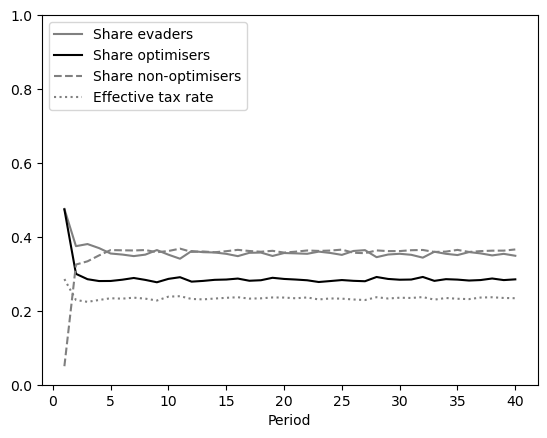

In [8]:
steps = 41
number_agents = 1000
setting = 1
audit_disclosure = 0
num_neighbors = 20
i_honest = 0.05
social_pressure = 0.1
network_kappa = 0.5
number_iterations = 10
tax_complexity = 2.09686
iterations_list = []
for iteration in tqdm(range(number_iterations)):
    model = Disclosure(N = number_agents, scen = setting, audit_discl = audit_disclosure, kappa = network_kappa, complexity = tax_complexity, blockingfour = 1, neighbors = num_neighbors, rho_upper = social_pressure, intr_honest = i_honest)
    for i in range(steps):
        model.step()
    results_temp_df = model.datacollector.get_model_vars_dataframe()
    results_temp_df['Run'] = iteration
    results_temp_df.insert(loc=0, column='Step', value=np.arange(len(results_temp_df)))
    iterations_list.append(results_temp_df)
results_df = pd.concat(iterations_list)
results_df.Run += 1
results_df = results_df.set_index(['Run', 'Step'])

""" Plot results and save figure """
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Evaders'], color='gray', label='Share evaders')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Avoiders'], color='black', label='Share optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Honest'], linestyle='dashed', color='gray', label='Share non-optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['TaxRev'], color='gray', linestyle='dotted', label='Effective tax rate')
plt.legend(loc="upper left")
plt.xlabel("Period")
plt.ylim([0,1])
plt.savefig(os.path.join('3_output', 'scenario1.svg'), format = 'svg', dpi=300)

Show mean values for strategies and effective tax rate in last period

In [39]:
results_df.groupby('Step').mean().loc[40]

Number of Honest      0.360200
Number of Avoiders    0.279600
Number of Evaders     0.360200
TaxRev                0.232991
Name: 40, dtype: float64

### Scenario 2

100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


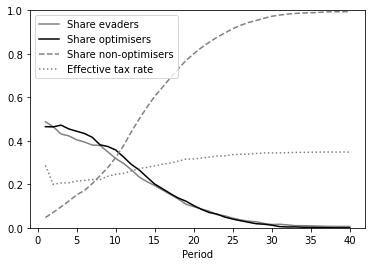

In [40]:
steps = 41
number_agents = 1000
setting = 2
audit_disclosure = 0
num_neighbors = 20
i_honest = 0.05
social_pressure = 0.1
network_kappa = 0.01
tax_complexity = 2.09686
number_iterations = 10
iterations_list = []
for iteration in tqdm(range(number_iterations)):
    model = Disclosure(N = number_agents, scen = setting, kappa = network_kappa, complexity = tax_complexity, audit_discl = audit_disclosure, blockingfour = 1, neighbors = num_neighbors, rho_upper = social_pressure, tax_rate = 0.35, intr_honest = i_honest)
    for i in range(steps):
        model.step()
    results_temp_df = model.datacollector.get_model_vars_dataframe()
    results_temp_df['Run'] = iteration
    results_temp_df.insert(loc=0, column='Step', value=np.arange(len(results_temp_df)))
    iterations_list.append(results_temp_df)
results_df = pd.concat(iterations_list)
results_df.Run += 1
results_df = results_df.set_index(['Run', 'Step'])

""" Plot results and save figure """
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Evaders'], color='gray', label='Share evaders')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Avoiders'], color='black', label='Share optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Honest'], linestyle='dashed', color='gray', label='Share non-optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['TaxRev'], color='gray', linestyle='dotted', label='Effective tax rate')
plt.legend(loc="upper left")
plt.xlabel("Period")
plt.ylim([0,1])
plt.savefig(os.path.join('3_output', 'scenario2.svg'), format = 'svg', dpi=300)

In [41]:
results_df.groupby('Step').mean().loc[40]

Number of Honest      0.99380
Number of Avoiders    0.00000
Number of Evaders     0.00620
TaxRev                0.34799
Name: 40, dtype: float64

### Scenario 3

100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


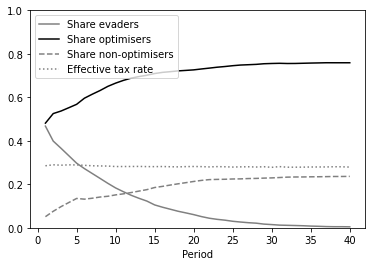

In [50]:
steps = 41
number_agents = 1000
setting = 3
audit_disclosure = 1
num_neighbors = 20
i_honest = 0.05
social_pressure = 0.1
network_kappa = 0.01
tax_complexity = 2.09686
number_iterations = 10
iterations_list = []
for iteration in tqdm(range(number_iterations)):
    model = Disclosure(N = number_agents, scen = setting, complexity = tax_complexity, kappa = network_kappa, audit_discl = audit_disclosure, blockingfour = 1, neighbors = num_neighbors, rho_upper = social_pressure, intr_honest = i_honest)
    for i in range(steps):
        model.step()
    results_temp_df = model.datacollector.get_model_vars_dataframe()
    results_temp_df['Run'] = iteration
    results_temp_df.insert(loc=0, column='Step', value=np.arange(len(results_temp_df)))
    iterations_list.append(results_temp_df)
results_df = pd.concat(iterations_list)
results_df.Run += 1
results_df = results_df.set_index(['Run', 'Step'])

""" Plot results and save figure """
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Evaders'], color='gray', label='Share evaders')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Avoiders'], color='black', label='Share optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['Number of Honest'], linestyle='dashed', color='gray', label='Share non-optimisers')
plt.plot(results_df.groupby('Step').mean().iloc[1: , :]['TaxRev'], color='gray', linestyle='dotted', label='Effective tax rate')
plt.legend(loc="upper left")
plt.xlabel("Period")
plt.ylim([0,1])
plt.savefig(os.path.join('3_output', 'scenario3.svg'), format = 'svg', dpi=300)

In [51]:
results_df.groupby('Step').mean().loc[40]

Number of Honest      0.236500
Number of Avoiders    0.759000
Number of Evaders     0.004500
TaxRev                0.279227
Name: 40, dtype: float64

## Badge Run (collects values at the last step only)

### Agent Level (not used in the paper)

Run the model

In [13]:
fixed_params = {"N": 1000}
variable_params = {"scen": range(1, 4, 1),
                   "audit_discl": range(0, 2, 1),
                   "kappa": [0, 0.01, 0.15],
                   "complexity": [1.167, 2.09686, 3.5]}

batch_run = BatchRunner(Disclosure,
                        variable_parameters = variable_params,
                        fixed_parameters = fixed_params,
                        iterations = 1,
                        max_steps = 41,
                        agent_reporters={"State": "state",
                             "Number Neighbors": "number_neighbors",
                             "Honest Neighbors": "number_honest_neighbors",
                             "Avoiding Neighbors": "number_avoider_neighbors",
                             "Evading Neighbors": "number_evader_neighbors",
                             "Caught Evader Neighbors": "number_unlucky_evader_neighbors",
                             "Evasion-Amount": "opt_evasion",
                             "Evasion-Value": "value_evasion",
                             "Avoidance-Amount": "opt_avoidance",
                             "Avoidance-Value": "value_avoidance",
                             "Honesty-Value": "value_honesty",
                             "Audit-Counter": "audit_counter",
                             "Audit-Prob": "audit_prob",
                             "Number Caught": "caught"}
                         )
batch_run.run_all()
run_agentdata_df = batch_run.get_agent_vars_dataframe()

54it [01:55,  2.14s/it]


In [14]:
run_agentdata_df

,scen,audit_discl,kappa,complexity,Run,AgentId,Audit-Counter,Audit-Prob,Avoidance-Amount,Avoidance-Value,...,Caught Evader Neighbors,Evading Neighbors,Evasion-Amount,Evasion-Value,Honest Neighbors,Honesty-Value,Number Caught,Number Neighbors,State,N
0,1,0,0.00,1.167,0,1,0,0.00,0.721152,-0.000942,...,0,10,1.000000,-0.000045,9,-0.001503,0,20,3,1000
658,1,0,0.00,1.167,0,659,0,0.00,0.976465,-0.000806,...,0,14,1.000000,-0.000045,5,-0.001503,0,20,1,1000
659,1,0,0.00,1.167,0,660,0,0.00,0.804221,-0.000893,...,0,13,1.000000,-0.000045,6,-0.001503,0,20,3,1000
660,1,0,0.00,1.167,0,661,0,0.00,0.742775,-0.000929,...,0,12,1.000000,-0.000045,6,-0.001503,0,20,3,1000
661,1,0,0.00,1.167,0,662,0,0.00,0.716747,-0.000945,...,0,14,1.000000,-0.000045,5,-0.001503,0,20,2,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53338,3,1,0.15,3.500,53,339,0,0.05,0.139452,-0.001491,...,0,0,0.104467,-0.001268,19,-0.001503,0,19,1,1000
53339,3,1,0.15,3.500,53,340,0,0.05,0.023060,-0.001503,...,0,0,0.104467,-0.001268,22,-0.001503,0,22,1,1000
53340,3,1,0.15,3.500,53,341,0,0.05,0.108150,-0.001496,...,0,0,0.104467,-0.001268,20,-0.001503,0,20,1,1000
53327,3,1,0.15,3.500,53,328,0,0.05,0.114123,-0.001495,...,0,0,0.104467,-0.001268,19,-0.001503,0,19,0,1000


Save data

In [52]:
run_agentdata_df.to_pickle(os.path.join('2_temp_files', 'agentdata.pkl'))

### Model Level

Note: Simulating all parameter combinations as shown in the paper takes a while. We therefore used the BachRunnerMP class which offers multiprocessing. The code for the model class, agent class, and calculation of aggregaten number class and BachRunnerMP simulation are contained in the file TRDisclosure.py. It saves the simulation results in ten temporary files saved in the folder 2_temp_files. This data is then analyzed in the file Data_Analysis.ipynb.

In [12]:
fixed_params = {"N": 1000, "blockingfour": 1, "neighbors": 20, "rho_upper": 0.1, "intr_honest": 0.05}
variable_params = {"scen": range(1, 4, 1),
                   "audit_discl": range(0, 2, 1)}

batch_run = BatchRunner(Disclosure,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=41,
                        model_reporters={"Number of Honest": agg_honest, "Number of Avoiders": agg_avoiders, "Number of Evaders": agg_evaders, "Tax": agg_taxrev})
batch_run.run_all()
run_modeldata_df = batch_run.get_model_vars_dataframe()

60it [02:34,  2.58s/it]


## Picture of the Graph

Shows network after one step (not used in the paper)

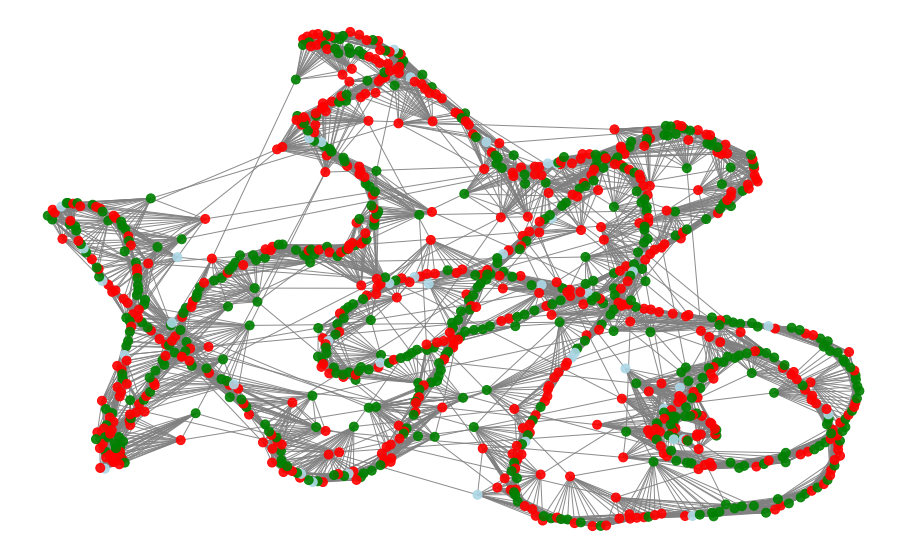

In [18]:
cmap = ListedColormap(["lightblue", "orange", "green", "red"])


def plot_grid(model,fig,layout='kamada-kawai',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    elif layout == "fruchterman-reingold":
        pos = nx.fruchterman_reingold_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=80, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = Disclosure(N = 1000)
model.step()
f=plot_grid(model,fig,layout='fruchterman-reingold')

## Structural Graph Properties (average over 50 runs)

### Average shortest path length

In [19]:
number_iterations = 50
length = 0
for i in tqdm(range(0, number_iterations)):
    model = Disclosure(N = 1000, neighbors = 20, kappa = 0.45)
    length += nx.average_shortest_path_length(model.G)
length = length / number_iterations
print(length)

100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]

2.7129661261261253


### Clustering coefficient

In [13]:
number_iterations = 50
clustering = 0
for i in tqdm(range(0, number_iterations)):
    model = Disclosure(N = 1000, neighbors = 20, kappa = 0.1)
    clustering += nx.average_clustering(model.G)
clustering = clustering / number_iterations
print(clustering)

100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.02it/s]

0.5223432117947485


## Export Graph for Gephi

<p>Note: Different behavioral types (evaders, avoiders, honest) are not depicted in the paper. Therefore, here, we simply construct a generic Watts/Strogatz model.</p>
<p>The model is saved in the 3_output folder and can be further analyzed or displayed, e.g., using Gephi</p>

In [20]:
test_G = nx.watts_strogatz_graph(n=1000, k=20, p=0.01)
nx.write_gexf(test_G, os.path.join('3_output', 'graph.gexf'))